## Analysis of  DV correlation decay
### jsharpna

1. DV correlation with quidel test positivity
2. general trends of variability in case proportions 

In [31]:
from delphi_epidata import Epidata
import covidcast
from datetime import date
import plotnine as p9
import matplotlib.pyplot as plt

In [81]:
start_date = date(2020, 7, 27)
end_date = date(2020, 8, 21)

test_sig = covidcast.signal("quidel", "covid_ag_smoothed_pct_positive",
                 start_day=start_date, end_day=end_date,
                 geo_type="hrr")

case_sig = covidcast.signal("usa-facts", "confirmed_7dav_incidence_prop",
                 start_day=start_date, end_day=end_date,
                 geo_type="hrr")

dv_sig = covidcast.signal("doctor-visits", "smoothed_cli",
                 start_day=start_date, end_day=end_date,
                 geo_type="hrr")

In [85]:
dv_sig.set_index(['geo_value','time_value'], inplace=True)
test_sig.set_index(['geo_value','time_value'], inplace=True)
case_sig.set_index(['geo_value','time_value'], inplace=True)

In [86]:
sig_df = dv_sig[['value']]

In [91]:
sig_df = sig_df.rename(columns = {'value': 'dv'})

In [114]:
sig_df['case_inc'] = case_sig['value']
sig_df['test_pos'] = test_sig['value']

In [115]:
sig_df

,,dv,case_inc,test_pos
geo_value,time_value,,,
1,2020-07-27,9.123611,37.737935,10.624887
10,2020-07-27,1.634266,13.142439,7.407407
101,2020-07-27,3.950085,5.823848,NaN
102,2020-07-27,5.137957,10.401591,NaN
103,2020-07-27,8.826621,11.080379,6.115108
...,...,...,...,...
87,2020-08-21,0.607247,12.740241,NaN
89,2020-08-21,1.795674,23.014264,NaN
9,2020-08-21,4.553409,25.052211,7.167235


In [116]:
sig_df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956 entries, 0 to 7955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   geo_value   7956 non-null   object        
 1   time_value  7956 non-null   datetime64[ns]
 2   dv          7956 non-null   float64       
 3   case_inc    7956 non-null   float64       
 4   test_pos    5795 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 310.9+ KB


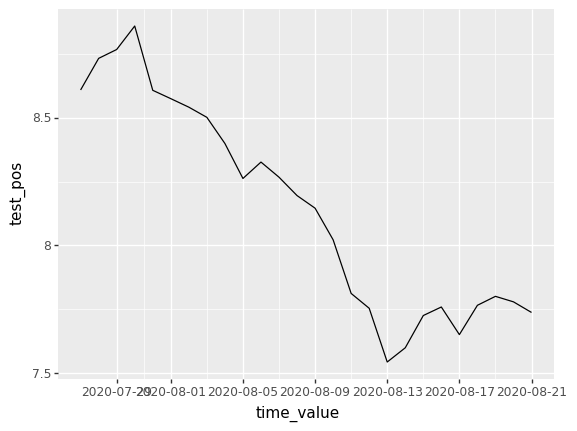

<ggplot: (8750753913809)>

In [122]:
p9.ggplot(sig_df.groupby(level=1).mean().reset_index(), p9.aes(x='time_value', y='test_pos')) + p9.geom_line()

/home/jsharpna/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


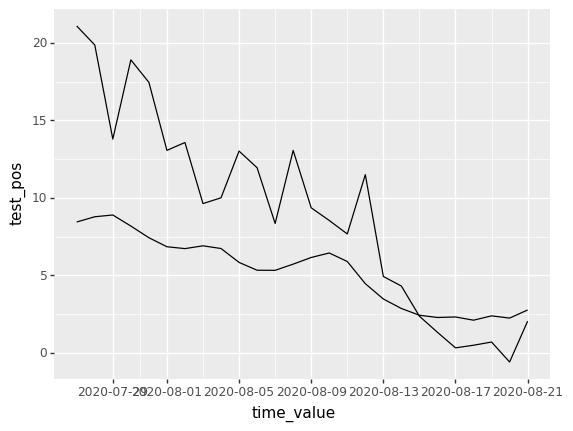

<ggplot: (8750753133545)>

In [133]:
plot_df = sig_df.diff().reset_index().query('geo_value == "9"')

p9.ggplot(plot_df)\
+ p9.geom_line(p9.aes(x='time_value', y='test_pos')) \
+ p9.geom_line(p9.aes(x='time_value', y='dv')) \
+ p9.geom_line(p9.aes(x='time_value', y='case_inc'))

In [141]:
slope_df = sig_df.diff().dropna()

In [142]:
slope_df

,,dv,case_inc,test_pos
geo_value,time_value,,,
10,2020-07-27,-7.489345,-24.595496,-3.217480
104,2020-07-27,-6.323930,-5.436146,-1.307416
11,2020-07-27,2.631499,35.091233,4.690341
110,2020-07-27,-7.525346,-36.600312,-5.512981
111,2020-07-27,1.196259,-0.776129,-0.359167
...,...,...,...,...
58,2020-08-21,-3.655385,13.999578,15.640139
6,2020-08-21,-2.190929,-9.588159,-6.847634
69,2020-08-21,-0.054534,7.115099,20.260557


In [144]:
sig_corr = sig_df.groupby(level=1).corr(method='spearman')

In [148]:
sig_corr_tidy = sig_corr.reset_index(level=1).query('level_1 == "dv"')[['case_inc','test_pos']]

In [151]:
sig_corr_tidy = sig_corr_tidy.rename(columns={'case_inc':'dv_case', 'test_pos':'dv_test'})

In [153]:
sig_corr_tidy['case_test'] = sig_corr.reset_index(level=1).query('level_1 == "case_inc"')['test_pos']

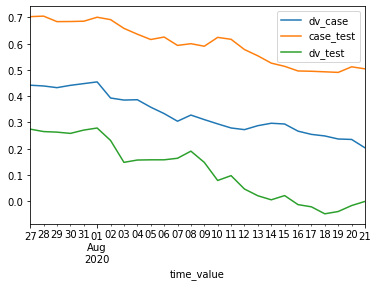

In [160]:
ax = sig_corr_tidy.plot(y='dv_case')
sig_corr_tidy.plot(y='case_test',ax=ax)
sig_corr_tidy.plot(y='dv_test', ax=ax)

**Hypothesis 1:** the DV signal correlation is deteriorating because more people who are visiting the doctor for CLI symptoms are in fact not infected with COVID

This would be explained by a perception that tests are more available, and increased comfort in going to a doctor's office.  If we suppose that the quidel test positivity rate is a good proxy for the infection rate in question (dubious), then hypo 1 might mean a deteriorating correlation between DV and Test positivity.  This is what we observe for quidel the test positivity becomes less correlated with the dv (green) eventually becoming 0.  This is for August (quidel not available before 7/27).  However, this could also be explained by some common cause for the deteriorating correlations, and the direction of causal arrows is ???.  This was done at hrr level.

In [168]:
start_date = date(2020, 5, 1)
end_date = date(2020, 8, 21)

case_sig = covidcast.signal("usa-facts", "confirmed_7dav_incidence_prop",
                 start_day=start_date, end_day=end_date,
                 geo_type="hrr")

dv_sig = covidcast.signal("doctor-visits", "smoothed_cli",
                 start_day=start_date, end_day=end_date,
                 geo_type="hrr")

KeyboardInterrupt: 

In [ ]:
dv_sig.set_index(['geo_value','time_value'], inplace=True)
case_sig.set_index(['geo_value','time_value'], inplace=True)

In [185]:
sig_df = dv_sig[['value']]
sig_df = sig_df.rename(columns = {'value': 'dv'})
sig_df['case_inc'] = case_sig['value']

In [186]:
sig_df

,,dv,case_inc
geo_value,time_value,,
1,2020-05-01,1.703336,3.020466
10,2020-05-01,4.758303,0.488204
101,2020-05-01,4.471740,6.759078
102,2020-05-01,2.457174,1.889845
103,2020-05-01,8.581514,9.376506
...,...,...,...
87,2020-08-21,0.607247,12.740241
89,2020-08-21,1.795674,23.014264
9,2020-08-21,4.553409,25.052211


In [201]:
sig_stats = sig_df.groupby(level=1).mean()

In [203]:
sig_stats = sig_stats.join((sig_df.groupby(level=1).quantile(.8) - sig_df.groupby(level=1).quantile(.2)) / sig_df.groupby(level=1).median(),
               rsuffix="_iqrr")

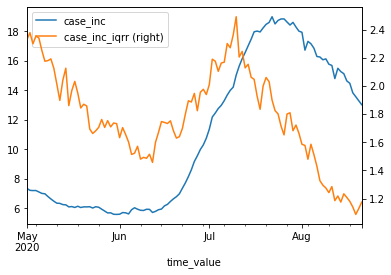

In [205]:
ax = sig_stats.plot(y='case_inc')
sig_stats.plot(y='case_inc_iqrr', secondary_y=True, ax = ax)

**Hypo 2:** The trends in correlations are due to changing variability in the case counts.

Below I plot the mean hrr case counts (blue) and iqrr which is the range from .8 to .2 quantiles divided by the median (yellow).  The yellow curve does show a similar pattern to the correlation plots.  And the explanation may be that when the iqrr is low the transmission is harder to predict because it is due to some "background" mixing that is hard to eliminate or detect.